config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 1804/1804 [03:29<00:00,  8.60batch/s, Avg Loss=1.76]


Epoch [1/10] - Avg Loss: 1.7638
Epoch [1/10] - Accuracy on Test Data: 0.5882


Epoch 2/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.66batch/s, Avg Loss=1.06]


Epoch [2/10] - Avg Loss: 1.0580
Epoch [2/10] - Accuracy on Test Data: 0.6755


Epoch 3/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.66batch/s, Avg Loss=0.822]


Epoch [3/10] - Avg Loss: 0.8220
Epoch [3/10] - Accuracy on Test Data: 0.7097


Epoch 4/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.65batch/s, Avg Loss=0.701]


Epoch [4/10] - Avg Loss: 0.7010
Epoch [4/10] - Accuracy on Test Data: 0.7387


Epoch 5/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.65batch/s, Avg Loss=0.611]


Epoch [5/10] - Avg Loss: 0.6111
Epoch [5/10] - Accuracy on Test Data: 0.7654


Epoch 6/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.66batch/s, Avg Loss=0.523]


Epoch [6/10] - Avg Loss: 0.5226
Epoch [6/10] - Accuracy on Test Data: 0.7835


Epoch 7/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.66batch/s, Avg Loss=0.451]


Epoch [7/10] - Avg Loss: 0.4511
Epoch [7/10] - Accuracy on Test Data: 0.8048


Epoch 8/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.67batch/s, Avg Loss=0.385]


Epoch [8/10] - Avg Loss: 0.3845
Epoch [8/10] - Accuracy on Test Data: 0.8164


Epoch 9/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.66batch/s, Avg Loss=0.321]


Epoch [9/10] - Avg Loss: 0.3206
Epoch [9/10] - Accuracy on Test Data: 0.8370


Epoch 10/10: 100%|██████████| 1804/1804 [03:28<00:00,  8.66batch/s, Avg Loss=0.271]


Epoch [10/10] - Avg Loss: 0.2714
Epoch [10/10] - Accuracy on Test Data: 0.8481


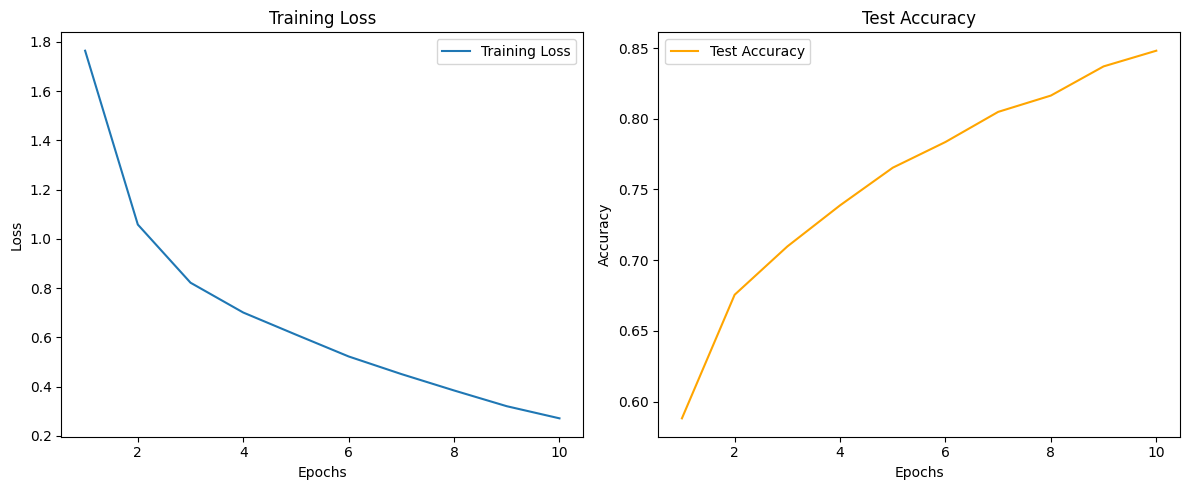

Evaluating: 100%|██████████| 451/451 [00:14<00:00, 30.82it/s]


Overall Performance Metrics:

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       628
           1       0.80      0.87      0.84       662
           2       0.85      0.89      0.87       636
           3       0.77      0.79      0.78       630
           4       0.92      0.88      0.90       646
           5       0.92      0.95      0.93       678
           6       0.80      0.81      0.81       629

    accuracy                           0.85      4509
   macro avg       0.85      0.85      0.85      4509
weighted avg       0.85      0.85      0.85      4509


Overall Accuracy: 0.8481


Per-Class Performance:

Class 0: Accuracy = 0.7468
Class 1: Accuracy = 0.8716
Class 2: Accuracy = 0.8868
Class 3: Accuracy = 0.7857
Class 4: Accuracy = 0.8762
Class 5: Accuracy = 0.9469
Class 6: Accuracy = 0.8124


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn.functional as F

# Custom Model Definition with T5 Encoder and CNN layer
class T5WithCNNForClassification(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(T5WithCNNForClassification, self).__init__()
        self.t5 = AutoModel.from_pretrained(base_model_name)
        hidden_size = self.t5.config.d_model
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(256, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        # Using the encoder part of T5
        outputs = self.t5.encoder(input_ids=input_ids, attention_mask=attention_mask)
        encoder_hidden_states = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]
        
        # Apply CNN layers
        encoder_hidden_states = encoder_hidden_states.permute(0, 2, 1)  # Change to [batch_size, hidden_size, seq_len] for CNN
        x = F.relu(self.conv1(encoder_hidden_states))  # Apply first CNN layer
        x = self.pool(x)  # Apply pooling
        x = F.relu(self.conv2(x))  # Apply second CNN layer
        x = self.pool(x)  # Apply pooling
        
        # Global max pooling over the sequence length dimension
        x = torch.max(x, dim=2)[0]  # Shape: [batch_size, 256]
        
        # Classification layer
        logits = self.fc(x)
        
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-base")

# Load dataset
df = pd.read_excel('/kaggle/input/combineddataset/combined dataset.xlsx')

# Split dataset
Comment_train, Comment_test, Label_train, Label_test = train_test_split(df['content'], df['labels'], test_size=0.2, random_state=18)

# Tokenize the data
encodedata_train = tokenizer.batch_encode_plus(
    Comment_train.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

encodedata_test = tokenizer.batch_encode_plus(
    Comment_test.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

# Prepare data for DataLoader
input_ids_train = encodedata_train['input_ids']
attention_masks_train = encodedata_train['attention_mask']
labels_train = torch.tensor(Label_train.to_numpy(), dtype=torch.long)

input_ids_test = encodedata_test['input_ids']
attention_masks_test = encodedata_test['attention_mask']
labels_test = torch.tensor(Label_test.to_numpy(), dtype=torch.long)

tensordataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
tensordataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

train_loader = DataLoader(tensordataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(tensordataset_test, batch_size=10, shuffle=False)

# Define model, loss function, and optimizer
model = T5WithCNNForClassification(base_model_name="t5-base", num_labels=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (progress_bar.n + 1)
        progress_bar.set_postfix({'Avg Loss': avg_loss})

    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_masks)
            _, predicted = torch.max(outputs['logits'], 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Accuracy on Test Data: {accuracy:.4f}')

# Plotting Loss and Accuracy graphs
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Detailed Performance Metrics Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs['logits']
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Performance metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, labels=list(range(7)), zero_division=1)
accuracy = accuracy_score(all_labels, all_preds)

print("\nOverall Performance Metrics:\n")
print(class_report)
print(f"\nOverall Accuracy: {accuracy:.4f}\n")

# Per-class performance
print("\nPer-Class Performance:\n")
for i in range(7):  # Adjust number of classes accordingly
    class_accuracy = conf_matrix[i, i] / conf_matrix[i, :].sum() if conf_matrix[i, :].sum() > 0 else 0
    print(f"Class {i}: Accuracy = {class_accuracy:.4f}")


##### 